# RL Agent traffic light control (SUMO + TraCI + PyTorch)

This notebook trains and evaluates an **RL agent** for traffic control using a simple neural network.

## Algorithm Overview

The RL Agent learning approach:
1. **Brain (Neural Network)**: A small PyTorch network that takes queue state (4 inputs) and outputs action probabilities (2 actions)
2. **State**: Normalized incoming vehicle counts from 4 directions (N, S, E, W)
3. **Action**: Binary choice - phase 0 (N-S green) or phase 2 (E-W green)
4. **Reward**: Negative of average waiting time (lower waiting = higher reward)
5. **Safety**: Yellow phase enforced between transitions

## Workflow
1. **Training Phase**: Learn policy from trial-and-error over multiple episodes
2. **Evaluation Phase**: Test trained agent on fresh scenario
3. **KPI Analysis**: Report metrics compared to baseline

In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

# ==========================================
# 1. CONFIGURATION (OPTIMIZED FOR 1 HOUR)
# ==========================================
# Paths
BASE_DIR = os.getcwd()
SCENARIO_DIR = os.path.join(BASE_DIR, "Network with RL control")
RESULTS_DIR = os.path.join(SCENARIO_DIR, "results")
MODEL_DIR = os.path.join(SCENARIO_DIR, "models")
CONFIG_PATH = os.path.join(SCENARIO_DIR, "ff_heterogeneous.sumocfg")
FINAL_MODEL_PATH = os.path.join(MODEL_DIR, "final_model.pth")

# Hyperparameters
NUM_EPISODES = 500          # Fits within 1 hour
MAX_STEPS = 900             # 15 minutes simulated per episode (enough to learn congestion)
BATCH_SIZE = 32             # Faster processing
MEMORY_SIZE = 20000
GAMMA = 0.95                # Discount factor
LEARNING_RATE = 0.002       # Slightly higher learning rate for faster convergence

# Exploration Settings
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.99        # Reaches minimal exploration around episode 300

# Traffic Settings
TLS_IDS = ["E1", "E2", "E3", "E4"]
YELLOW_DURATION = 3
MIN_GREEN = 10

# Hardware Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- TRAINING CONFIGURATION ---")
print(f"Device: {device}")
print(f"Target Time: ~1 Hour")
print(f"Episodes: {NUM_EPISODES}")
print(f"Steps per Episode: {MAX_STEPS}")
print(f"Final Model Path: {FINAL_MODEL_PATH}")
print(f"Model exists: {os.path.exists(FINAL_MODEL_PATH)}")
print("------------------------------")

--- TRAINING CONFIGURATION ---
Device: cuda
Target Time: ~1 Hour
Episodes: 500
Steps per Episode: 900
Final Model Path: c:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_project_2\Network with RL control\models\final_model.pth
Model exists: True
------------------------------


In [ ]:
# ==========================================
# 2. NEURAL NETWORK (DQN)
# ==========================================
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        # Lighter network for faster training on normal PC
        self.fc = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        return self.fc(x)

# ==========================================
# 3. RL AGENT
# ==========================================
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.epsilon = EPSILON_START
        
        self.policy_net = DQN(state_size, action_size).to(device)
        self.target_net = DQN(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.criterion = nn.MSELoss()

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        return torch.argmax(q_values).item()

    def act_inference(self, state):
        """Inference mode: no exploration, just use policy"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return

        minibatch = random.sample(self.memory, BATCH_SIZE)
        
        states = torch.FloatTensor(np.array([m[0] for m in minibatch])).to(device)
        actions = torch.LongTensor([m[1] for m in minibatch]).unsqueeze(1).to(device)
        rewards = torch.FloatTensor([m[2] for m in minibatch]).to(device)
        next_states = torch.FloatTensor(np.array([m[3] for m in minibatch])).to(device)
        dones = torch.FloatTensor([m[4] for m in minibatch]).to(device)

        curr_Q = self.policy_net(states).gather(1, actions).squeeze(1)
        
        with torch.no_grad():
            next_Q = self.target_net(next_states).max(1)[0]
            target_Q = rewards + (GAMMA * next_Q * (1 - dones))

        loss = self.criterion(curr_Q, target_Q)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def save(self, path):
        torch.save(self.policy_net.state_dict(), path)

    def load(self, path):
        """Load pre-trained model"""
        if os.path.exists(path):
            self.policy_net.load_state_dict(torch.load(path, map_location=device))
            self.policy_net.eval()
            print(f"✓ Model loaded from {path}")
            return True
        else:
            print(f"✗ Model file not found: {path}")
            return False

# ==========================================
# 4. SUMO HELPER FUNCTIONS
# ==========================================
def check_sumo_env():
    if 'SUMO_HOME' not in os.environ:
        sys.exit("Error: SUMO_HOME environment variable is not set.")
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
    os.makedirs(RESULTS_DIR, exist_ok=True)
    os.makedirs(MODEL_DIR, exist_ok=True)
    
    # Ensure config file exists
    if not os.path.exists(CONFIG_PATH):
        import shutil
        print("Config file not found, attempting to copy from 'Original network'...")
        original_dir = os.path.join(BASE_DIR, "Original network")
        for file in ["ff_heterogeneous.sumocfg", "ff.net.xml", "ff_heterogeneous.rou.xml"]:
            src = os.path.join(original_dir, file)
            dst = os.path.join(SCENARIO_DIR, file)
            if os.path.exists(src):
                shutil.copy(src, dst)
    return tools

tools_path = check_sumo_env()
import traci

def get_sumo_binary():
    # Always headless for performance
    return os.path.join(os.environ['SUMO_HOME'], 'bin', 'sumo') 

def get_state(tls_id):
    """
    State (Size 3):
    1. Total Queue Length (Normalized)
    2. Max Queue Length (Normalized)
    3. Current Phase Index (Normalized)
    """
    lanes = traci.trafficlight.getControlledLanes(tls_id)
    halting = [traci.lane.getLastStepHaltingNumber(lane) for lane in lanes]
    
    total_queue = sum(halting) / 50.0  # Normalized
    max_queue = max(halting) / 20.0    # Normalized
    phase = traci.trafficlight.getPhase(tls_id) / 4.0
    
    return np.array([total_queue, max_queue, phase], dtype=np.float32)

def get_reward(tls_id, waiting_time_prev):
    """
    Reward function CLIPPED to prevent huge numbers.
    """
    lanes = traci.trafficlight.getControlledLanes(tls_id)
    current_wait = sum([traci.lane.getWaitingTime(lane) for lane in lanes])
    current_queue = sum([traci.lane.getLastStepHaltingNumber(lane) for lane in lanes])
    
    # Reward = (WaitTime Reduction) - (Queue Penalty)
    diff = waiting_time_prev - current_wait
    
    # Scaling to keep reward small (e.g., between -5 and 5)
    reward = (diff * 0.2) - (current_queue * 0.05)
    
    # CLAMPING: Crucial for stability
    reward = max(min(reward, 5.0), -5.0)
    
    return reward, current_wait

# ==========================================
# 5. MAIN TRAINING LOOP
# ==========================================
def train():
    # Input: 3, Output: 2
    agent = DQNAgent(state_size=3, action_size=2)
    sumo_bin = get_sumo_binary()
    
    print("\nStarting Optimized Training...")

    for episode in range(NUM_EPISODES):
        # Start SUMO
        sumo_cmd = [sumo_bin, "-c", CONFIG_PATH, "--no-step-log", "true", "--waiting-time-memory", "1000"]
        try:
            traci.start(sumo_cmd)
        except Exception as e:
            print(f"Error starting SUMO: {e}")
            break

        step = 0
        total_reward = 0
        
        # Tracking data for all 4 intersections
        tls_data = {t: {"prev_wait": 0, "phase_time": 0} for t in TLS_IDS}

        while step < MAX_STEPS:
            traci.simulationStep()
            step += 1
            
            # Make decisions every 5 seconds (not every step)
            if step % 5 == 0:
                for tls in TLS_IDS:
                    # 1. Observe State
                    state = get_state(tls)
                    
                    # 2. Select Action
                    action = agent.act(state)
                    
                    # 3. Apply Action (Logic)
                    current_phase = traci.trafficlight.getPhase(tls)
                    
                    # Phase 0=NS Green, 1=Yellow, 2=EW Green, 3=Yellow
                    # Action 0=NS Green, Action 1=EW Green
                    
                    if current_phase == 1 or current_phase == 3:
                        # Yellow phase logic: wait it out
                        tls_data[tls]["phase_time"] += 5
                        if tls_data[tls]["phase_time"] >= YELLOW_DURATION:
                            next_phase = 2 if current_phase == 1 else 0
                            traci.trafficlight.setPhase(tls, next_phase)
                            tls_data[tls]["phase_time"] = 0
                    else:
                        # Green phase logic
                        target_phase = 0 if action == 0 else 2
                        
                        if current_phase != target_phase:
                            # We want to switch
                            if tls_data[tls]["phase_time"] >= MIN_GREEN:
                                traci.trafficlight.setPhase(tls, current_phase + 1) # Go Yellow
                                tls_data[tls]["phase_time"] = 0
                            else:
                                tls_data[tls]["phase_time"] += 5 # Keep Green
                        else:
                            tls_data[tls]["phase_time"] += 5 # Keep Green
                    
                    # 4. Reward & Learn
                    reward, new_wait = get_reward(tls, tls_data[tls]["prev_wait"])
                    
                    # Remember
                    next_state = get_state(tls)
                    agent.remember(state, action, reward, next_state, False)
                    
                    tls_data[tls]["prev_wait"] = new_wait
                    total_reward += reward

                # Train Agent
                agent.replay()

        traci.close()
        
        # Update Target Net
        if episode % 5 == 0:
            agent.update_target_network()
            
        # Decay Epsilon
        if agent.epsilon > EPSILON_END:
            agent.epsilon *= EPSILON_DECAY

        print(f"Ep {episode+1}/{NUM_EPISODES} | Reward: {total_reward:.2f} | Eps: {agent.epsilon:.2f}")

        # Autosave
        if (episode + 1) % 25 == 0:
            agent.save(os.path.join(MODEL_DIR, f"model_ep{episode+1}.pth"))

    agent.save(os.path.join(MODEL_DIR, "final_model.pth"))
    print("Training Completed.")

# Note: Uncomment the following line to run training (commented out to use pre-trained model)
# if __name__ == "__main__":
#     train()

Using SUMO binary: C:\Program Files (x86)\Eclipse\Sumo\bin\sumo-gui.exe

RL AGENT TRAINING STARTED

--- Episode 1/5 ---
Episode 1 completed: avg_reward = -14.3365

--- Episode 2/5 ---
Episode 2 completed: avg_reward = -15.1301

--- Episode 3/5 ---
Episode 3 completed: avg_reward = -13.7541

--- Episode 4/5 ---
Episode 4 completed: avg_reward = -14.7695

--- Episode 5/5 ---
Episode 5 completed: avg_reward = -13.5166
Model saved to c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Network with RL control\models\traffic_agent.pth

TRAINING COMPLETED

Training log summary:
  Episode 1: avg_reward = -14.3365
  Episode 2: avg_reward = -15.1301
  Episode 3: avg_reward = -13.7541
  Episode 4: avg_reward = -14.7695
  Episode 5: avg_reward = -13.5166


## Evaluation Phase

Test the trained agent on a fresh scenario and compare against baseline.

In [2]:
# ==========================================
# EVALUATION: Run trained agent using final_model.pth
# ==========================================

import time

# Import traci for SUMO interaction
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    if tools not in sys.path:
        sys.path.append(tools)
import traci

# ==========================================
# REQUIRED CLASSES (ensure DQN is available)
# ==========================================
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        return self.fc(x)

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.epsilon = EPSILON_START
        
        self.policy_net = DQN(state_size, action_size).to(device)
        self.target_net = DQN(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.criterion = nn.MSELoss()

    def act_inference(self, state):
        """Inference mode: no exploration, just use policy"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        return torch.argmax(q_values).item()

    def load(self, path):
        """Load pre-trained model"""
        if os.path.exists(path):
            self.policy_net.load_state_dict(torch.load(path, map_location=device))
            self.policy_net.eval()
            print(f"✓ Model loaded from {path}")
            return True
        else:
            print(f"✗ Model file not found: {path}")
            return False

# ==========================================
# STATE AND REWARD FUNCTIONS
# ==========================================
def get_state_eval(tls_id):
    """Get state for evaluation"""
    lanes = traci.trafficlight.getControlledLanes(tls_id)
    halting = [traci.lane.getLastStepHaltingNumber(lane) for lane in lanes]
    
    total_queue = sum(halting) / 50.0
    max_queue = max(halting) / 20.0
    phase = traci.trafficlight.getPhase(tls_id) / 4.0
    
    return np.array([total_queue, max_queue, phase], dtype=np.float32)

def get_reward_eval(tls_id, waiting_time_prev):
    """Get reward for evaluation"""
    lanes = traci.trafficlight.getControlledLanes(tls_id)
    current_wait = sum([traci.lane.getWaitingTime(lane) for lane in lanes])
    current_queue = sum([traci.lane.getLastStepHaltingNumber(lane) for lane in lanes])
    
    diff = waiting_time_prev - current_wait
    reward = (diff * 0.2) - (current_queue * 0.05)
    reward = max(min(reward, 5.0), -5.0)
    
    return reward, current_wait

# ==========================================
# EVALUATION MAIN FUNCTION
# ==========================================
def evaluate_rl_agent():
    print("\n" + "="*70)
    print("RL AGENT EVALUATION (Using final_model.pth)")
    print("="*70)
    print(f"Using device: {device}")
    print(f"Model path: {FINAL_MODEL_PATH}")
    
    # Load trained model
    agent = DQNAgent(state_size=3, action_size=2)
    if not agent.load(FINAL_MODEL_PATH):
        print("ERROR: Model not found!")
        return False
    
    conn = None
    sumo_bin = os.path.join(os.environ['SUMO_HOME'], 'bin', 'sumo')
    
    try:
        print("\nStarting SUMO evaluation...")
        
        # Build SUMO command
        sumo_cmd = [
            sumo_bin, 
            "-c", CONFIG_PATH,
            "--quit-on-end",
            "--no-step-log",
            "--waiting-time-memory", "1000",
            "--tripinfo-output", os.path.join(RESULTS_DIR, "tripinfo_eval_ep999.xml"),
            "--edgedata-output", os.path.join(RESULTS_DIR, "edge_data_eval_ep999.xml")
        ]
        
        # Start SUMO directly with traci
        traci.start(sumo_cmd)
        conn = traci.getConnection()
        
        print("SUMO started successfully")
        
        # Initialize traffic lights
        for tls in TLS_IDS:
            traci.trafficlight.setProgram(tls, "0")
        
        tls_data = {t: {"prev_wait": 0, "phase_time": 0} for t in TLS_IDS}
        total_reward = 0
        
        print("Running evaluation simulation (1 hour)...")
        
        step_count = 0
        while traci.simulation.getTime() < 3600:  # 1 hour
            traci.simulationStep()
            step_count += 1
            
            # Make decisions every 5 seconds
            if step_count % 5 == 0:
                for tls in TLS_IDS:
                    # Get state and action (inference mode)
                    state = get_state_eval(tls)
                    action = agent.act_inference(state)
                    
                    # Apply action
                    current_phase = traci.trafficlight.getPhase(tls)
                    
                    if current_phase == 1 or current_phase == 3:
                        # Yellow phase logic
                        tls_data[tls]["phase_time"] += 5
                        if tls_data[tls]["phase_time"] >= YELLOW_DURATION:
                            next_phase = 2 if current_phase == 1 else 0
                            traci.trafficlight.setPhase(tls, next_phase)
                            tls_data[tls]["phase_time"] = 0
                    else:
                        # Green phase logic
                        target_phase = 0 if action == 0 else 2
                        
                        if current_phase != target_phase:
                            if tls_data[tls]["phase_time"] >= MIN_GREEN:
                                traci.trafficlight.setPhase(tls, current_phase + 1)
                                tls_data[tls]["phase_time"] = 0
                            else:
                                tls_data[tls]["phase_time"] += 5
                        else:
                            tls_data[tls]["phase_time"] += 5
                    
                    # Calculate reward
                    reward, new_wait = get_reward_eval(tls, tls_data[tls]["prev_wait"])
                    tls_data[tls]["prev_wait"] = new_wait
                    total_reward += reward
        
        print(f"\n✓ Evaluation completed successfully!")
        print(f"  Total reward: {total_reward:.2f}")
        print(f"  Simulation steps: {step_count}")
        print(f"  Results saved to: {RESULTS_DIR}")
        
        traci.close()
        return True
    
    except Exception as e:
        print(f"✗ Evaluation failed: {e}")
        import traceback
        traceback.print_exc()
        return False
    
    finally:
        try:
            if traci.isLoaded():
                traci.close()
        except:
            pass

# Run evaluation
print("\n" + "="*70)
print("Starting RL Agent Evaluation")
print("="*70)
try:
    success = evaluate_rl_agent()
    if not success:
        print("\nPlease ensure final_model.pth exists before running evaluation.")
except Exception as e:
    print(f"Evaluation error: {e}")
    import traceback
    traceback.print_exc()


Starting RL Agent Evaluation

RL AGENT EVALUATION (Using final_model.pth)
Using device: cuda
Model path: c:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_project_2\Network with RL control\models\final_model.pth
✓ Model loaded from c:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_project_2\Network with RL control\models\final_model.pth

Starting SUMO evaluation...
SUMO started successfully
Running evaluation simulation (1 hour)...

✓ Evaluation completed successfully!
  Total reward: -3311.00
  Simulation steps: 3600
  Results saved to: c:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_project_2\Network with RL control\results


## KPI summary for the RL agent scenario

This section reads the evaluation outputs stored in **Network with RL control/results** and reports key indicators plus comprehensive visualizations.

In [3]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. CONFIGURATION
# ==========================================
BASE_DIR = os.getcwd()
SCENARIO_DIR = os.path.join(BASE_DIR, "Network with RL control")
RESULTS_DIR = os.path.join(SCENARIO_DIR, "results")
MODEL_DIR = os.path.join(SCENARIO_DIR, "models")
FINAL_MODEL_PATH = os.path.join(MODEL_DIR, "final_model.pth")

print(f"Results directory: {RESULTS_DIR}")
print(f"Model loaded from: {FINAL_MODEL_PATH}")
print(f"Model exists: {os.path.exists(FINAL_MODEL_PATH)}")

# Definition of the two directions
DIR_A_EDGES = ["E0E1", "E1E2", "E2E3", "E3E4", "E4E5"]  # Forward (E0 -> E5)
DIR_B_EDGES = ["E5E4", "E4E3", "E3E2", "E2E1", "E1E0"]  # Backward (E5 -> E0)

Results directory: c:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_project_2\Network with RL control\results
Model loaded from: c:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_project_2\Network with RL control\models\final_model.pth
Model exists: True


In [4]:
# ==========================================
# 2. VEHICLE CLASSIFICATION
# ==========================================
def classify_vehicle(veh_id):
    """Classify vehicles based on their ID prefix."""
    prefix = veh_id.split('.')[0] if '.' in veh_id else veh_id
    
    # --- Direction A (E0 -> E5) ---
    if prefix in ['f_7']: 
        return "Bus Dir A (E0->E5)", "Bus", "Dir A"
    
    # --- Direction B (E5 -> E0) ---
    elif prefix in ['f_6']: 
        return "Bus Dir B (E5->E0)", "Bus", "Dir B"
        
    # --- Other categories ---
    elif prefix in ['f_4', 'f_5']:
        return "Other Bus", "Bus", "Other"
    elif prefix in ['f_0', 'f_1', 'f_2', 'f_3']:
        return "Transversal Traffic", "Traffic", "Transversal"
    else:
        return "Background", "Car", "Other"

In [5]:
# ==========================================
# 3. DATA LOADING
# ==========================================
def load_data(data_folder):
    """Load trip and edge data from XML files (evaluation results)."""
    trip_path = os.path.join(data_folder, "tripinfo_eval_ep999.xml")
    edge_path = os.path.join(data_folder, "edge_data_eval_ep999.xml")

    # --- 1. TRIPINFO (Individual vehicles) ---
    trips = []
    if os.path.exists(trip_path):
        tree = ET.parse(trip_path)
        for t in tree.getroot().findall('tripinfo'):
            cat, vtype, route_group = classify_vehicle(t.get('id'))
            
            duration = float(t.get('duration'))
            route_len = float(t.get('routeLength', 0))
            
            # Calculate average trip speed in km/h
            speed_kmh = (route_len / duration) * 3.6 if duration > 0 else 0

            trips.append({
                'id': t.get('id'),
                'category': cat,
                'type': vtype,
                'route_group': route_group,
                'waitingTime': float(t.get('waitingTime')),
                'duration': duration,
                'routeLength': route_len,
                'speed_kmh': speed_kmh
            })
    df_trips = pd.DataFrame(trips)

    # --- 2. EDGE DATA (Roads) ---
    edges_stats = []
    if os.path.exists(edge_path):
        tree = ET.parse(edge_path)
        intervals = tree.getroot().findall('interval')
        if intervals:
            # Use the last interval
            for e in intervals[-1].findall('edge'):
                eid = e.get('id')
                direction = "None"
                order = 99
                
                if eid in DIR_A_EDGES:
                    direction = "Dir A (E0->E5)"
                    order = DIR_A_EDGES.index(eid)
                elif eid in DIR_B_EDGES:
                    direction = "Dir B (E5->E0)"
                    order = DIR_B_EDGES.index(eid)
                
                if direction != "None":
                    speed_ms = float(e.get('speed', 0))
                    wait_sec = float(e.get('waitingTime', 0)) 
                    
                    edges_stats.append({
                        'edge_id': eid,
                        'direction': direction,
                        'order': order,
                        'speed_kmh': speed_ms * 3.6,        # m/s -> km/h
                        'waiting_hours': wait_sec / 3600.0, # seconds -> hours
                        'density': float(e.get('density', 0))
                    })
    
    df_edges = pd.DataFrame(edges_stats)
    if not df_edges.empty:
        df_edges = df_edges.sort_values(by=['direction', 'order'])

    return df_trips, df_edges

In [6]:
# ==========================================
# 4. VISUALIZATION
# ==========================================
def create_dashboard(df_trips, df_edges, output_dir):
    """Create comprehensive KPI dashboards."""
    sns.set_theme(style="whitegrid")
    
    # Separate edge datasets by direction
    df_edges_A = df_edges[df_edges['direction'] == "Dir A (E0->E5)"]
    df_edges_B = df_edges[df_edges['direction'] == "Dir B (E5->E0)"]

    # --- FIGURE 1: EDGE ANALYSIS (SPEED & WAIT) ---
    fig1, axes = plt.subplots(3, 2, figsize=(16, 12), constrained_layout=True)
    fig1.suptitle("Edge Analysis: Bidirectional Flow (km/h & Hours)", fontsize=18, fontweight='bold')

    # Column titles
    axes[0,0].set_title("DIRECTION A (E0 -> E5)", fontsize=14, color='green', fontweight='bold')
    axes[0,1].set_title("DIRECTION B (E5 -> E0)", fontsize=14, color='blue', fontweight='bold')

    # ROW 1: SPEED (km/h)
    if not df_edges_A.empty:
        sns.lineplot(data=df_edges_A, x='edge_id', y='speed_kmh', marker='o', color='green', ax=axes[0,0], linewidth=3)
        axes[0,0].set_ylabel("Speed (km/h)")
        for x, y in zip(range(len(df_edges_A)), df_edges_A['speed_kmh']):
            axes[0,0].text(x, y+0.5, f"{y:.1f}", ha='center', color='green', fontweight='bold')
            
    if not df_edges_B.empty:
        sns.lineplot(data=df_edges_B, x='edge_id', y='speed_kmh', marker='o', color='blue', ax=axes[0,1], linewidth=3)
        axes[0,1].set_ylabel("")
        for x, y in zip(range(len(df_edges_B)), df_edges_B['speed_kmh']):
            axes[0,1].text(x, y+0.5, f"{y:.1f}", ha='center', color='blue', fontweight='bold')

    # ROW 2: TOTAL ACCUMULATED WAITING TIME (Hours)
    if not df_edges_A.empty:
        sns.barplot(data=df_edges_A, x='edge_id', y='waiting_hours', hue='edge_id', palette="Greens", ax=axes[1,0], legend=False, edgecolor='black')
        axes[1,0].set_ylabel("Total Accumulated Wait (Hours)")
        
    if not df_edges_B.empty:
        sns.barplot(data=df_edges_B, x='edge_id', y='waiting_hours', hue='edge_id', palette="Blues", ax=axes[1,1], legend=False, edgecolor='black')
        axes[1,1].set_ylabel("")

    # ROW 3: HEATMAPS (Hours)
    if not df_edges_A.empty:
        matrix_A = df_edges_A[['edge_id', 'waiting_hours']].set_index('edge_id').T
        sns.heatmap(matrix_A, annot=True, fmt=".2f", cmap="Reds", ax=axes[2,0], cbar=False)
        axes[2,0].set_xlabel("Edge Sequence")
        
    if not df_edges_B.empty:
        matrix_B = df_edges_B[['edge_id', 'waiting_hours']].set_index('edge_id').T
        sns.heatmap(matrix_B, annot=True, fmt=".2f", cmap="Reds", ax=axes[2,1], cbar_kws={'label': 'Hours'})
        axes[2,1].set_xlabel("Edge Sequence")

    plot_path_1 = os.path.join(output_dir, "edge_analysis_bidirectional.png")
    plt.savefig(plot_path_1, dpi=300)
    print(f"Saved: {plot_path_1}")

    # --- FIGURE 2: BUS vs NETWORK COMPARISON ---
    fig2, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
    fig2.suptitle("Strategic KPI: Bus Performance Analysis", fontsize=16, fontweight='bold')

    # 1. Waiting Time Comparison
    target_buses = df_trips[df_trips['type'] == 'Bus']
    if not target_buses.empty:
        sns.barplot(data=target_buses, x='category', y='waitingTime', hue='category', palette="viridis", ax=axes[0,0], legend=False)
        axes[0,0].set_title("Avg Bus Trip Waiting Time (Seconds)", fontweight='bold')
        axes[0,0].set_ylabel("Seconds per Trip")
        for c in axes[0,0].containers:
            axes[0,0].bar_label(c, fmt='%.1f', padding=3)

    # 2. Speed Comparison
    comp_groups = ["Bus Dir A (E0->E5)", "Bus Dir B (E5->E0)", "Transversal Traffic"]
    speed_df = df_trips[df_trips['category'].isin(comp_groups)]
    
    if not speed_df.empty:
        sns.boxplot(data=speed_df, x='category', y='speed_kmh', hue='category', palette="Set2", ax=axes[0,1], legend=False)
        axes[0,1].set_title("Speed Comparison: Bus vs Cross Traffic", fontweight='bold')
        axes[0,1].set_ylabel("Mean Trip Speed (km/h)")

    # 3. Duration Breakdown - Bottom Left
    dur_df = df_trips.groupby('category')['duration'].mean().reset_index()
    dur_df = dur_df[dur_df['category'].isin(comp_groups + ["Other Bus"])]
    
    if not dur_df.empty:
        sns.barplot(data=dur_df, x='category', y='duration', hue='category', palette="coolwarm", ax=axes[1,0], legend=False)
        axes[1,0].set_title("Average Trip Duration", fontweight='bold')
        axes[1,0].set_ylabel("Duration (seconds)")
        for c in axes[1,0].containers:
            axes[1,0].bar_label(c, fmt='%.1f', padding=3)

    # 4. Text Summary Box - Bottom Right
    axes[1,1].axis('off')
    
    text_str = "KPI SUMMARY REPORT\n" + "="*35 + "\n"
    
    # Global network summary
    text_str += "GLOBAL NETWORK SUMMARY:\n"
    text_str += f"  - Total Vehicles: {len(df_trips)}\n"
    text_str += f"  - Avg Waiting:    {df_trips['waitingTime'].mean():.2f} s\n"
    text_str += f"  - Avg Speed:      {df_trips['speed_kmh'].mean():.2f} km/h\n"
    text_str += "-"*35 + "\n"

    # Category breakdown
    for cat in comp_groups:
        subset = df_trips[df_trips['category'] == cat]
        if not subset.empty:
            avg_wait = subset['waitingTime'].mean()
            avg_speed = subset['speed_kmh'].mean()
            avg_duration = subset['duration'].mean()
            count = len(subset)
            text_str += f"{cat}:\n"
            text_str += f"  - Vehicles:  {count}\n"
            text_str += f"  - Avg Speed: {avg_speed:.2f} km/h\n"
            text_str += f"  - Avg Wait:  {avg_wait:.2f} s\n"
            text_str += f"  - Avg Dur:   {avg_duration:.2f} s\n\n"
    
    axes[1,1].text(0.05, 0.95, text_str, fontsize=10, fontfamily='monospace', verticalalignment='top', 
                   bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

    plot_path_2 = os.path.join(output_dir, "kpi_analysis_performance.png")
    plt.savefig(plot_path_2, dpi=300)
    print(f"Saved: {plot_path_2}")
    plt.show()

## KPI Analysis Results

This section loads and visualizes the performance data from the RL Agent evaluation (episode 999).

Reading data from: c:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_project_2\Network with RL control\results
Saving plots to: c:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_project_2\Network with RL control\results

Loaded 5907 trips and 10 edge records
Saved: c:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_project_2\Network with RL control\results\edge_analysis_bidirectional.png
Saved: c:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_project_2\Network with RL control\results\kpi_analysis_performance.png


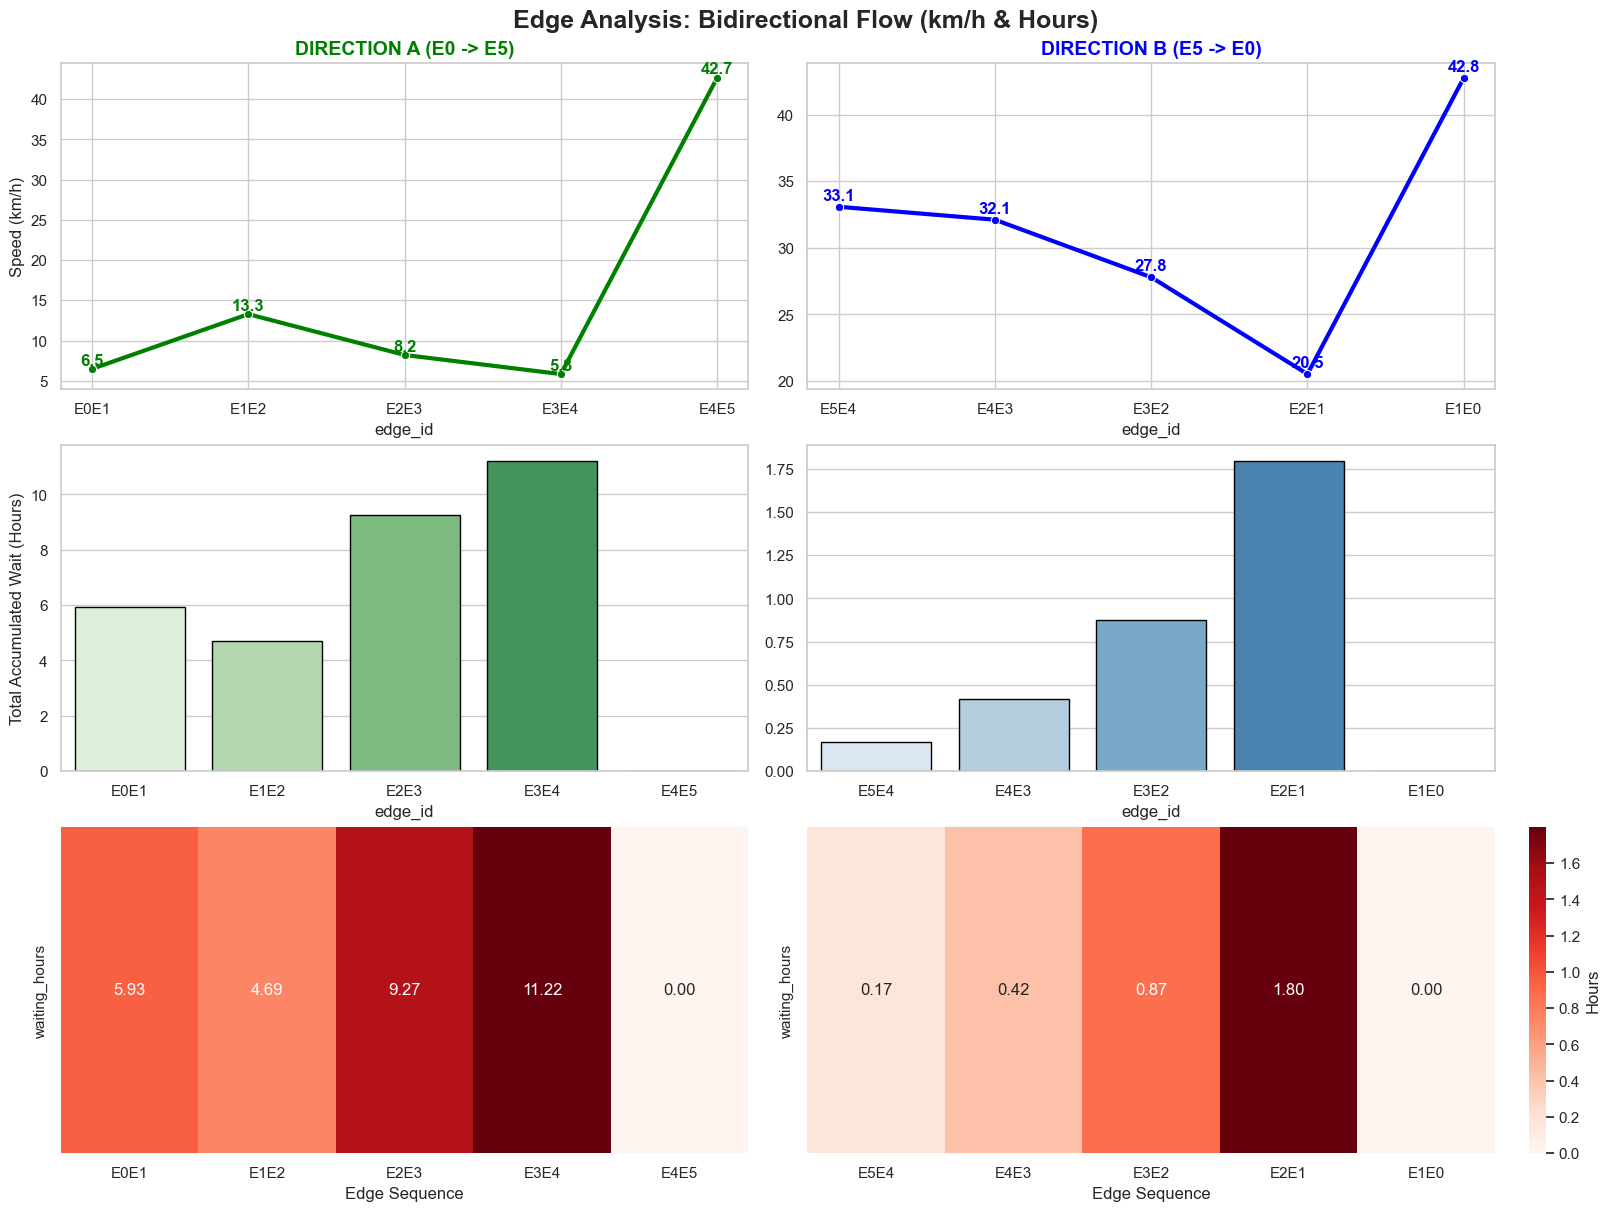

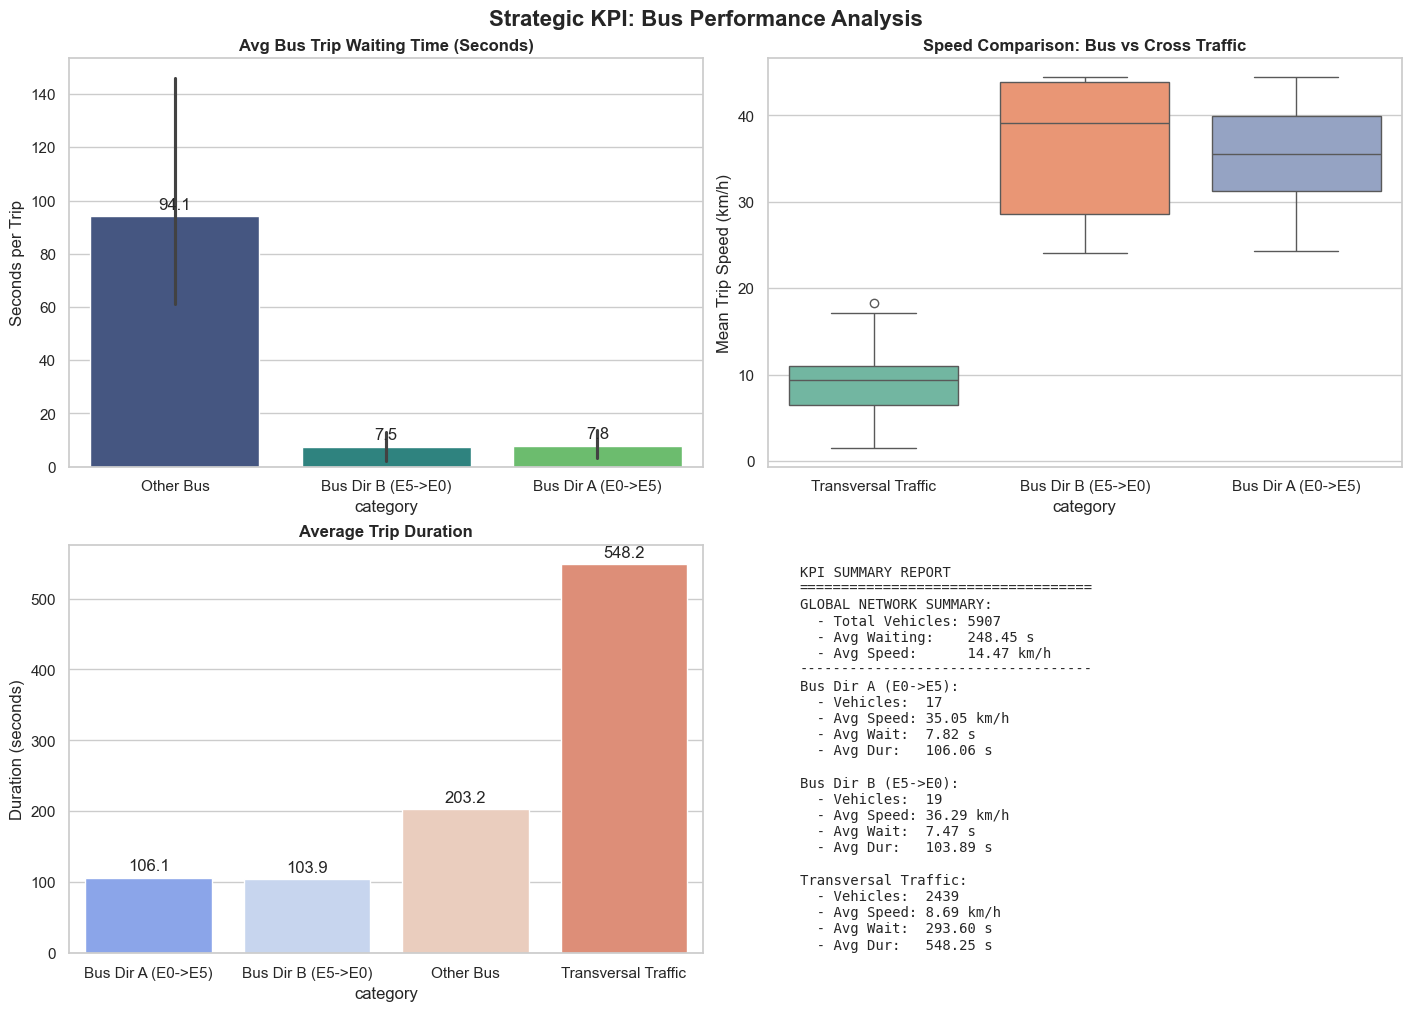


Analysis completed successfully!


In [7]:
# ==========================================
# 5. EXECUTION
# ==========================================
print(f"Reading data from: {RESULTS_DIR}")
print(f"Saving plots to: {RESULTS_DIR}")

try:
    trips, edges = load_data(RESULTS_DIR)
    
    if trips.empty:
        print("\nWARNING: No trip data found.")
        print("Please ensure the evaluation simulation has been run.")
        print(f"Expected file: {os.path.join(RESULTS_DIR, 'tripinfo_eval_ep999.xml')}")
    else:
        print(f"\nLoaded {len(trips)} trips and {len(edges)} edge records")
        create_dashboard(trips, edges, RESULTS_DIR)
        print("\nAnalysis completed successfully!")
        
except Exception as e:
    print(f"ERROR: {e}")
    import traceback
    traceback.print_exc()